# Working with microsecond time-series

Here we are going to explore some important concepts you will need to do your home assigment when using high requency time series of financial markets

For this, we are going to work with the following dataset



## TRD Data: Structure, Location, and Interpretation

This section summarizes **only the trade (TRD)** files from the dataset, how they are organized on disk, how they should be interpreted, and the key rules for cleaning and processing them.

---

## 1. Where the TRD Files Live (Directory Layout)

Your working directory contains a folder called `DATA/`.  
Inside it, there is **one subfolder per venue per trading date**, for example:

- `BME_2025-11-07/`
- `TURQUOISE_2025-11-07/`
- `CBOE_2025-11-07/`
- `AQUIS_2025-11-07/`

Each of these venue–date folders contains gzip-compressed, semicolon-separated CSV files of three types:

- `QTE_*.csv.gz` — order book snapshots  
- `TRD_*.csv.gz` — **trades**  
- `STS_*.csv.gz` — market trading status  

For the purposes of this document, only the `TRD_*.csv.gz` files matter.

### File Naming Pattern

All files follow:

```
<type>*<session>*<isin>*<ticker>*<mic>_<part>.csv.gz
```


Where:


   
*type*: `TRD`
- **session**: trading date (`YYYY-MM-DD`)
- **isin**: cross-venue ISIN
- **ticker**: venue-specific symbol (multiple books for the same ISIN may exist)
- **mic**: segment MIC (e.g., `XMAD`)
- **part**: integer; if multiple `part` values exist for the same identity,  
  **only the highest part number must be processed**, and you should emit a warning.

---

## 2. Identity & Join Keys (Relevant for Trades)

A single order book identity is defined as:



(session, isin, mic, ticker)



All TRD files belonging to this identity correspond to trades occurring on the same order book.

---

## 3. Time Semantics for TRD

All timestamps use:

- **epoch** = microseconds since Unix epoch (UTC)
- Feeds are **perfectly synchronized** across file types (no skew adjustments)

When multiple trades share the same epoch:

- TRD rows are ordered by **ascending sequence**  
  (lowest sequence = earliest event at that timestamp)

---

## 4. TRD (Trade) Files

### Columns



session
inst_id
sequence
isin
ticker
mic
currency
epoch
auction_on_demand_mic
aggressor_side
trade_id
mmt_flags
mmt_flags_version
px
qty
securityTradingId
bloombergTicker
lastTradePriceCurrency



### Column Semantics

- **aggressor_side**
  - `1` = buy-initiated trade  
  - `2` = sell-initiated  
  - empty = unknown  


- **px, qty**
  - Trade price and quantity.

- **mmt_flags**
  - The first two characters encode the most important trade attributes:
    - **First character** (Market Model) examples:  
      `1=CLOB`, `3=Dark`, `4=Off Book`, `5=Periodic Auction`, etc.
    - **Second character** (Trade Mode) examples:  
      `2=Continuous`, `K=Opening Auction`, `I=Closing Auction`, `4=Out of Main Session`, etc.

- **Off-book trades**
  - Valid TRD entries may include off-book prints.  
  - They **do not influence** addressability (that comes from QTE and STS only).



In [2]:
import pandas as pd
import numpy as np

# --- 1. Load the Data (Using your existing files) ---
# We assume the files are in the folder structure you provided
path_xmad = 'DATA_BIG/BME_2025-11-07/TRD_2025-11-07_ES0113900J37_SAN_XMAD_1.csv.gz'
path_ceux = 'DATA_BIG/CBOE_2025-11-07/TRD_2025-11-07_ES0113900J37_SANe_CEUX_1.csv.gz'

# Load BME (Madrid)
df_xmad = pd.read_csv(path_xmad, sep=';', compression='gzip')

# Load CBOE (Europe)
df_ceux = pd.read_csv(path_ceux, sep=';', compression='gzip')

print(f"Loaded {len(df_xmad)} rows from XMAD")
print(f"Loaded {len(df_ceux)} rows from CEUX")

Loaded 14454 rows from XMAD
Loaded 10883 rows from CEUX


 ## Preparing the data
Let's prepare the data step by step and then later we encapsulate it in a function

In [30]:
df = df_xmad.copy()
display(df.head())
df_1 = df_ceux.copy()
display(df_1.head())

,session,inst_id,sequence,isin,ticker,mic,currency,epoch,auction_on_demand_mic,aggressor_side,trade_id,mmt_flags,mmt_flags_version,px,qty,securityTradingId,bloombergTicker,lastTradePriceCurrency
0,2025-11-07,499123198,3,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg21,1O-------P----,V4,8.985,73,SAN,NaN,NaN
1,2025-11-07,499123198,4,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg22,1O-------PH---,V4,8.985,607,SAN,NaN,NaN
2,2025-11-07,499123198,5,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg23,1O-------PH---,V4,8.985,1,SAN,NaN,NaN
3,2025-11-07,499123198,6,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg24,1O-------PH---,V4,8.985,11,SAN,NaN,NaN
4,2025-11-07,499123198,7,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg25,1O-------PH---,V4,8.985,60,SAN,NaN,NaN


,session,inst_id,sequence,isin,ticker,mic,currency,epoch,auction_on_demand_mic,aggressor_side,trade_id,mmt_flags,mmt_flags_version,px,qty,securityTradingId,bloombergTicker,lastTradePriceCurrency
0,2025-11-07,306937000,5,ES0113900J37,SANe,CEUX,EUR,1762502419135370,NaN,NaN,6347497298097,5P--------H---,V4,8.985,2199,SANe,NaN,NaN
1,2025-11-07,306937000,6,ES0113900J37,SANe,CEUX,EUR,1762502419474745,NaN,1.0,6347497298131,12--------H---,V4,8.990,14033,SANe,NaN,NaN
2,2025-11-07,306937000,7,ES0113900J37,SANe,CEUX,EUR,1762502419475908,NaN,1.0,6347497298132,12--------H---,V4,8.992,11,SANe,NaN,NaN
3,2025-11-07,306937000,8,ES0113900J37,SANe,CEUX,EUR,1762502419476253,NaN,1.0,6347497298133,12--------H---,V4,8.995,435,SANe,NaN,NaN
4,2025-11-07,306937000,9,ES0113900J37,SANe,CEUX,EUR,1762502419480379,NaN,1.0,6347497298134,12--------H---,V4,8.988,228,SANe,NaN,NaN


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14454 entries, (Timestamp('2025-11-07 08:00:17.000449'), np.int64(3)) to (Timestamp('2025-11-07 16:35:11.000198'), np.int64(14459))
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   session                 14454 non-null  object 
 1   inst_id                 14454 non-null  int64  
 2   isin                    14454 non-null  object 
 3   ticker                  14454 non-null  object 
 4   mic                     14454 non-null  object 
 5   currency                14454 non-null  object 
 6   epoch                   14454 non-null  int64  
 7   auction_on_demand_mic   0 non-null      float64
 8   aggressor_side          0 non-null      float64
 9   trade_id                14454 non-null  object 
 10  mmt_flags               14454 non-null  object 
 11  mmt_flags_version       14454 non-null  object 
 12  px                      14454 non-null

In [4]:
# 1. Sort strictly
df = df.sort_values(by=['epoch', 'sequence'], ascending=[True, True])

# We can see how there are many trades happening at exactly the same epoch! 
# This is common in the stock exchange, when an aggressive order executes against many passive orders in the orderbook 
# at the same or differ price levels, the exchange reports one transaction at a time but all with the same timestamp
display(df.head())

,session,inst_id,sequence,isin,ticker,mic,currency,epoch,auction_on_demand_mic,aggressor_side,trade_id,mmt_flags,mmt_flags_version,px,qty,securityTradingId,bloombergTicker,lastTradePriceCurrency
0,2025-11-07,499123198,3,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg21,1O-------P----,V4,8.985,73,SAN,NaN,NaN
1,2025-11-07,499123198,4,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg22,1O-------PH---,V4,8.985,607,SAN,NaN,NaN
2,2025-11-07,499123198,5,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg23,1O-------PH---,V4,8.985,1,SAN,NaN,NaN
3,2025-11-07,499123198,6,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg24,1O-------PH---,V4,8.985,11,SAN,NaN,NaN
4,2025-11-07,499123198,7,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg25,1O-------PH---,V4,8.985,60,SAN,NaN,NaN


In [5]:
# It is a good idea to have an index without duplicates. Otherwise, many future transformations will trigger an error
# because the require unique index values (e.g. merge_asof)
duplicates = df.duplicated(subset='epoch', keep=False).sum()
print(f"Found {duplicates} trades sharing the same microsecond.")

Found 8694 trades sharing the same microsecond.


### How to treat a timeseries with events happening at exactly the same time

We need to find a strategy to work with this. The simplest strategy is often the best, but it is not always acceptable depending on the requirements.

In [6]:
# Option 1: Good for orderbooksnapshots but not valid for trades because you lose them
# Orderbook snapshots that happen on the same microsecond for us are virtually non existing. The only thing we see
# is the last orderbook of the microsecond. Therefore for orderbooksnapshots it is valide to keep only the last.
df_clean = df.drop_duplicates(subset='epoch', keep='last').copy()
display(df_clean.head())


,session,inst_id,sequence,isin,ticker,mic,currency,epoch,auction_on_demand_mic,aggressor_side,trade_id,mmt_flags,mmt_flags_version,px,qty,securityTradingId,bloombergTicker,lastTradePriceCurrency
430,2025-11-07,499123198,433,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNhPN,1O-------PH---,V4,8.985,2523,SAN,NaN,NaN
431,2025-11-07,499123198,434,ES0113900J37,SAN,XMAD,EUR,1762502417411050,NaN,NaN,B4u4JJYUyimfNhhJ,12-------PH---,V4,8.985,840,SAN,NaN,NaN
434,2025-11-07,499123198,437,ES0113900J37,SAN,XMAD,EUR,1762502417411071,NaN,NaN,B4u4JJYUyimfNhhM,12-------PH---,V4,8.987,2000,SAN,NaN,NaN
436,2025-11-07,499123198,439,ES0113900J37,SAN,XMAD,EUR,1762502417411115,NaN,NaN,B4u4JJYUyimfNhhO,12-------PH---,V4,8.987,2000,SAN,NaN,NaN
439,2025-11-07,499123198,442,ES0113900J37,SAN,XMAD,EUR,1762502417411145,NaN,NaN,B4u4JJYUyimfNhhR,12-------PH---,V4,8.988,1319,SAN,NaN,NaN


In [7]:
# Option 2 (Intermediate): the nanoseconds trick
temp_ts = pd.to_datetime(df['epoch'], unit='us')
display(temp_ts)

0       2025-11-07 08:00:17.000449
1       2025-11-07 08:00:17.000449
2       2025-11-07 08:00:17.000449
3       2025-11-07 08:00:17.000449
4       2025-11-07 08:00:17.000449
                   ...            
14449   2025-11-07 16:35:11.000198
14450   2025-11-07 16:35:11.000198
14451   2025-11-07 16:35:11.000198
14452   2025-11-07 16:35:11.000198
14453   2025-11-07 16:35:11.000198
Name: epoch, Length: 14454, dtype: datetime64[ns]

In [8]:
# standard groupby().cumcount() numbers the items in a group: 0, 1, 2, 3...
# We group by 'epoch' to find trades happening at the same time.
# We treat that count as Nanoseconds.

# Basically, for every trade, we count how many trades had the same epoch before, this is like a counter that allow us to separate trades 
offset_ns = df.groupby('epoch').cumcount()
display(offset_ns)

0          0
1          1
2          2
3          3
4          4
        ... 
14449    380
14450    381
14451    382
14452    383
14453    384
Length: 14454, dtype: int64

In [9]:
# We check that there are not more than 1000 executions at the same microsecond
# If there were more, this trick could cause issues, since the trade 1001 would be assigned to the next microsecond
max(offset_ns)

430

In [10]:
# Create the final High-Res Timestamp
# Base Time (us) + Offset (ns)
df['ts'] = temp_ts + pd.to_timedelta(offset_ns, unit='ns')
df.set_index('ts', inplace=True)
display(df.head())

,session,inst_id,sequence,isin,ticker,mic,currency,epoch,auction_on_demand_mic,aggressor_side,trade_id,mmt_flags,mmt_flags_version,px,qty,securityTradingId,bloombergTicker,lastTradePriceCurrency
ts,,,,,,,,,,,,,,,,,,
2025-11-07 08:00:17.000449000,2025-11-07,499123198,3,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg21,1O-------P----,V4,8.985,73,SAN,NaN,NaN
2025-11-07 08:00:17.000449001,2025-11-07,499123198,4,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg22,1O-------PH---,V4,8.985,607,SAN,NaN,NaN
2025-11-07 08:00:17.000449002,2025-11-07,499123198,5,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg23,1O-------PH---,V4,8.985,1,SAN,NaN,NaN
2025-11-07 08:00:17.000449003,2025-11-07,499123198,6,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg24,1O-------PH---,V4,8.985,11,SAN,NaN,NaN
2025-11-07 08:00:17.000449004,2025-11-07,499123198,7,ES0113900J37,SAN,XMAD,EUR,1762502417000449,NaN,NaN,B4u4JJYUyimfNg25,1O-------PH---,V4,8.985,60,SAN,NaN,NaN


In [11]:
# Option 3 (Advanced): Set MultiIndex
# We keep 'epoch' as a column too, just in case we need the raw int later
df['ts'] = pd.to_datetime(df['epoch'], unit='us')
df.set_index(['ts', 'sequence'], inplace=True)
display(df.head())

# The problem of this method is that it prevent us from using the merge_asof which is very useful when timestamps do not repeat.
# For the purpose of this lecture, we will use this approach. In real life, you would not pivot the data and you would rather process the full stream of data tick by tick
# This makes it much more complex, so we can explore a sufficiently valid approach for our use case which does not require
# the utmost precission. 

# Also this approach will be useful for your homework


session    inst_id          isin  \
ts                         sequence                                        
2025-11-07 08:00:17.000449 3         2025-11-07  499123198  ES0113900J37   
                           4         2025-11-07  499123198  ES0113900J37   
                           5         2025-11-07  499123198  ES0113900J37   
                           6         2025-11-07  499123198  ES0113900J37   
                           7         2025-11-07  499123198  ES0113900J37   

                                    ticker   mic currency             epoch  \
ts                         sequence                                           
2025-11-07 08:00:17.000449 3           SAN  XMAD      EUR  1762502417000449   
                           4           SAN  XMAD      EUR  1762502417000449   
                           5           SAN  XMAD      EUR  1762502417000449   
                           6           SAN  XMAD      EUR  1762502417000449   
                           7           SAN  XMAD      EUR  1762502417000449   

                                     auction_on_demand_mic  aggressor_side  \
ts                         sequence                                          
2025-11-07 08:00:17.000449 3                           NaN             NaN   
                           4                           NaN             NaN   
                           5                           NaN             NaN   
                           6                           NaN             NaN   
                           7                           NaN             NaN   

                                             trade_id       mmt_flags  \
ts                         sequence                                     
2025-11-07 08:00:17.000449 3         B4u4JJYUyimfNg21  1O-------P----   
                           4         B4u4JJYUyimfNg22  1O-------PH---   
                           5         B4u4JJYUyimfNg23  1O-------PH---   
                           6         B4u4JJYUyimfNg24  1O-------PH---   
                           7         B4u4JJYUyimfNg25  1O-------PH---   

                                    mmt_flags_version     px  qty  \
ts                         sequence                                 
2025-11-07 08:00:17.000449 3                       V4  8.985   73   
                           4                       V4  8.985  607   
                           5                       V4  8.985    1   
                           6                       V4  8.985   11   
                           7                       V4  8.985   60   

                                    securityTradingId  bloombergTicker  \
ts                         sequence                                      
2025-11-07 08:00:17.000449 3                      SAN              NaN   
                           4                      SAN              NaN   
                           5                      SAN              NaN   
                           6                      SAN              NaN   
                           7                      SAN              NaN   

                                     lastTradePriceCurrency  
ts                         sequence                          
2025-11-07 08:00:17.000449 3                            NaN  
                           4                            NaN  
                           5                            NaN  
                           6                            NaN  
                           7                            NaN

In [12]:
# For simplicity and to be able to use merge_asof we will go for Option 3.
# Here is the whole process encapsulated
def clean_hft_data_preserve_all(df):
    """
    1. Sorts by Epoch and Sequence.
    2. Identifies duplicates.
    3. Adds a 'nanosecond' offset to duplicates to make time unique.
    4. Sets unique Index.
    """
    # 1. Sort strictly
    df = df.sort_values(by=['epoch', 'sequence'], ascending=[True, True])
    
    # 2. Convert to basic Timestamp (Microseconds)
    # We do this temporarily to get the base time
    temp_ts = pd.to_datetime(df['epoch'], unit='us')
    
    # 3. The "Nanosecond Trick"
    # standard groupby().cumcount() numbers the items in a group: 0, 1, 2, 3...
    # We group by 'epoch' to find trades happening at the same time.
    # We treat that count as Nanoseconds.
    
    offset_ns = df.groupby('epoch').cumcount()
    
    if max(offset_ns)>1000:
        raise(f"There are more than 1000 executions happening at the same microsecond. Max number of execs: {offset_ns}")
    
    # 4. Create the final High-Res Timestamp
    # Base Time (us) + Offset (ns)
    df['ts'] = temp_ts + pd.to_timedelta(offset_ns, unit='ns')
    
    # 5. Set Index
    df.set_index('ts', inplace=True)
    
    return df

# Apply the new logic
print("--- Processing XMAD (Preserving All) ---")
df_xmad_full = clean_hft_data_preserve_all(df_xmad)

print("\n--- Processing CEUX (Preserving All) ---")
df_ceux_full = clean_hft_data_preserve_all(df_ceux)

# Verify Uniqueness
print(f"\nIs XMAD index unique now? {df_xmad_full.index.is_unique}")

# Let's inspect a "Burst" (Trades that happened at the same microsecond)
# We look for where the nanosecond part is not zero
bursts = df_xmad_full[df_xmad_full.index.nanosecond > 0]

if not bursts.empty:
    print("\nExample of a resolved collision (Look at the timestamps!):")
    # Show the base trade (ns=0) and the offset trade (ns=1)
    t_base = bursts.index[0].replace(nanosecond=0)
    print(df_xmad_full.loc[t_base : t_base + pd.Timedelta(nanoseconds=5), ['px', 'qty']])
else:
    print("No collisions found in this slice, but the code is ready for them.")

--- Processing XMAD (Preserving All) ---

--- Processing CEUX (Preserving All) ---

Is XMAD index unique now? True

Example of a resolved collision (Look at the timestamps!):
                                  px  qty
ts                                       
2025-11-07 08:00:17.000449000  8.985   73
2025-11-07 08:00:17.000449001  8.985  607
2025-11-07 08:00:17.000449002  8.985    1
2025-11-07 08:00:17.000449003  8.985   11
2025-11-07 08:00:17.000449004  8.985   60
2025-11-07 08:00:17.000449005  8.985    1


### Building the Consolidated Tape

Now that we have cleaned the data for both venues (Madrid and CBOE Europe), we need to combine them into a single view of the market. This is often called a **Consolidated Tape**.

**The Challenge: Asynchronous Data**
Financial markets are *asynchronous*. A trade happens on BME at `t=100`, and a trade happens on CBOE at `t=105`. They never align perfectly.

If we just join them, we will have gaps (NaNs). To solve this, we use the **Last Traded Price (LTP)** logic:
> *"If a trade didn't happen on this venue at this exact microsecond, the valid price is still the price of the **last** trade that did happen."*

**The Solution:**
1. **Concat & Sort:** Put all trades in one long list sorted by time.
2. **Pivot:** Create columns for each venue (`XMAD`, `CEUX`).
3. **Forward Fill (`ffill`):** This is the magic step. It propagates the last known valid observation forward to the next valid index.

In [13]:
# 1. Combine
tape_full = pd.concat([df_xmad_full, df_ceux_full])
tape_full.sort_index(inplace=True)

# 2. Pivot
# Now strict uniqueness is guaranteed, so pivot works perfectly
tape_pivot = tape_full.pivot(columns='mic', values='px')

# 3. Fill Forward
# This propagates the last valid price to the nanosecond level
consolidated_tape = tape_pivot.ffill()

print(f"Total Updates in Tape: {len(consolidated_tape)}")
print(consolidated_tape.head())

Total Updates in Tape: 25337
mic                            CEUX   XMAD
ts                                        
2025-11-07 08:00:17.000449000   NaN  8.985
2025-11-07 08:00:17.000449001   NaN  8.985
2025-11-07 08:00:17.000449002   NaN  8.985
2025-11-07 08:00:17.000449003   NaN  8.985
2025-11-07 08:00:17.000449004   NaN  8.985


mic,CEUX,XMAD,spread
ts,,,
2025-11-07 08:00:17.000449000,NaN,8.985,NaN
2025-11-07 08:00:17.000449001,NaN,8.985,NaN
2025-11-07 08:00:17.000449002,NaN,8.985,NaN
2025-11-07 08:00:17.000449003,NaN,8.985,NaN
2025-11-07 08:00:17.000449004,NaN,8.985,NaN
...,...,...,...
2025-11-07 16:36:15.093153003,8.849,8.849,0.0
2025-11-07 16:36:15.093153004,8.849,8.849,0.0
2025-11-07 16:36:15.093153005,8.849,8.849,0.0


<Axes: title={'center': 'Price Difference (XMAD - CEUX) in Euros'}, xlabel='ts'>

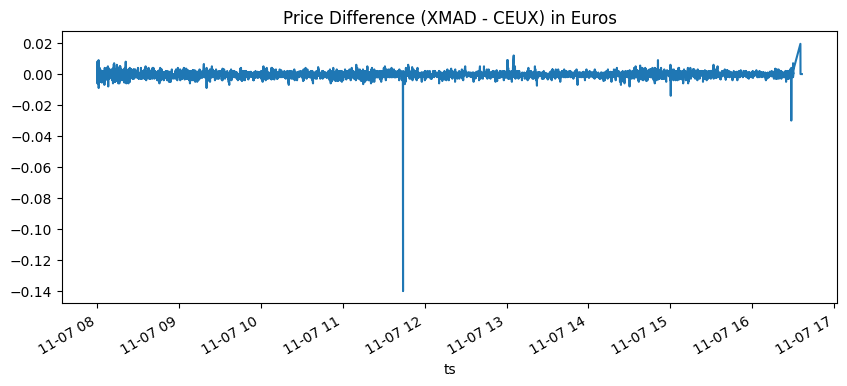

In [14]:
# Instant Vectorized Calculation
consolidated_tape['spread'] = consolidated_tape['XMAD'] - consolidated_tape['CEUX']
display(consolidated_tape)
# Visualize the discrepancy
consolidated_tape['spread'].plot(title="Price Difference (XMAD - CEUX) in Euros", figsize=(10, 4))

### Merging Low-Frequency Data (News) with High-Frequency Data (Trades)

We often need to enrich our trade data with external events (News, Macro announcements, Tweets). However, we face a major problem: **Timestamp Mismatch**.

* **News arrives at:** `11:40:00.000000`
* **Trade happens at:** `11:40:00.005231`

A standard SQL-style `left_join` or pandas `merge` requires an **exact match**. Since the timestamps rarely match down to the microsecond, a standard merge would result in almost all data being lost.

**The Solution: `merge_asof`**
Pandas `merge_asof` allows for **inexact matches**. It tells the computer:
> *"For every trade, look **backwards** in time and find the most recent news headline that appeared before this trade."*

* **`direction='backward'`**: Ensures we avoid "look-ahead bias." We only tag a trade with news that was already public when the trade occurred.

In [15]:
# 1. Create the News Dataframe
news_data = pd.DataFrame([
    {'ts': '2025-11-07 11:00:00', 'headline': 'Market Open', 'sentiment': 'NEUTRAL'},
    {'ts': '2025-11-07 11:40:00', 'headline': 'RUMOR: Acquisition Talks', 'sentiment': 'POSITIVE'},
    {'ts': '2025-11-07 12:10:00', 'headline': 'CORRECTION: Rumor Denied', 'sentiment': 'NEGATIVE'}
])

# Convert news time to datetime
news_data['ts'] = pd.to_datetime(news_data['ts'])
news_data.sort_values('ts', inplace=True)
display(news_data)

,ts,headline,sentiment
0,2025-11-07 11:00:00,Market Open,NEUTRAL
1,2025-11-07 11:40:00,RUMOR: Acquisition Talks,POSITIVE
2,2025-11-07 12:10:00,CORRECTION: Rumor Denied,NEGATIVE


In [16]:
# Reset index slightly to make 'ts' a column for merging
tape_reset = consolidated_tape.reset_index()

# Perform the As-Of Merge
tagged_trades = pd.merge_asof(
    tape_reset,             # Left Table (High Frequency - Trades)
    news_data,              # Right Table (Low Frequency - News)
    on='ts',                # The Time Column
    direction='backward'    # Look into the past, never the future!
)



display(tagged_trades)

,ts,CEUX,XMAD,spread,headline,sentiment
0,2025-11-07 08:00:17.000449000,NaN,8.985,NaN,NaN,NaN
1,2025-11-07 08:00:17.000449001,NaN,8.985,NaN,NaN,NaN
2,2025-11-07 08:00:17.000449002,NaN,8.985,NaN,NaN,NaN
3,2025-11-07 08:00:17.000449003,NaN,8.985,NaN,NaN,NaN
4,2025-11-07 08:00:17.000449004,NaN,8.985,NaN,NaN,NaN
...,...,...,...,...,...,...
25332,2025-11-07 16:36:15.093153003,8.849,8.849,0.0,CORRECTION: Rumor Denied,NEGATIVE
25333,2025-11-07 16:36:15.093153004,8.849,8.849,0.0,CORRECTION: Rumor Denied,NEGATIVE
25334,2025-11-07 16:36:15.093153005,8.849,8.849,0.0,CORRECTION: Rumor Denied,NEGATIVE
25335,2025-11-07 16:36:15.093153006,8.849,8.849,0.0,CORRECTION: Rumor Denied,NEGATIVE


In [17]:
tagged_trades.set_index("ts",inplace=True)
tagged_trades.head()

,CEUX,XMAD,spread,headline,sentiment
ts,,,,,
2025-11-07 08:00:17.000449000,NaN,8.985,NaN,NaN,NaN
2025-11-07 08:00:17.000449001,NaN,8.985,NaN,NaN,NaN
2025-11-07 08:00:17.000449002,NaN,8.985,NaN,NaN,NaN
2025-11-07 08:00:17.000449003,NaN,8.985,NaN,NaN,NaN
2025-11-07 08:00:17.000449004,NaN,8.985,NaN,NaN,NaN


In [18]:
tagged_trades

,CEUX,XMAD,spread,headline,sentiment
ts,,,,,
2025-11-07 08:00:17.000449000,NaN,8.985,NaN,NaN,NaN
2025-11-07 08:00:17.000449001,NaN,8.985,NaN,NaN,NaN
2025-11-07 08:00:17.000449002,NaN,8.985,NaN,NaN,NaN
2025-11-07 08:00:17.000449003,NaN,8.985,NaN,NaN,NaN
2025-11-07 08:00:17.000449004,NaN,8.985,NaN,NaN,NaN
...,...,...,...,...,...
2025-11-07 16:36:15.093153003,8.849,8.849,0.0,CORRECTION: Rumor Denied,NEGATIVE
2025-11-07 16:36:15.093153004,8.849,8.849,0.0,CORRECTION: Rumor Denied,NEGATIVE
2025-11-07 16:36:15.093153005,8.849,8.849,0.0,CORRECTION: Rumor Denied,NEGATIVE


In [19]:
# Let's check the result of the merge_asof
tagged_trades.between_time("11:39:40","11:40:05")

,CEUX,XMAD,spread,headline,sentiment
ts,,,,,
2025-11-07 11:39:41.318720,8.8340,8.835,0.0010,Market Open,NEUTRAL
2025-11-07 11:39:54.508561,8.8345,8.835,0.0005,Market Open,NEUTRAL
2025-11-07 11:39:54.964038,8.8345,8.833,-0.0015,Market Open,NEUTRAL
2025-11-07 11:40:00.802947,8.8340,8.833,-0.0010,RUMOR: Acquisition Talks,POSITIVE
2025-11-07 11:40:00.803186,8.8340,8.833,-0.0010,RUMOR: Acquisition Talks,POSITIVE


### Market Microstructure: Filtering "Dirty" Trades

Not all trades in a file represent the "current market price."

* **Lit Order Book (CLOB):** Trades that happen automatically by matching buyers and sellers in the public queue. These form the price.
* **Off-Book / OTC:** Large trades negotiated privately (e.g., over the phone) and reported to the exchange later.

**Why filter Off-Book trades?**
Off-book trades might be reported minutes or hours after they were actually agreed upon. If we include them in our time-series, they might appear as massive price spikes (outliers) because they represent a price from the past, not the current millisecond.

We use **MMT Flags** (Market Model Typology) to identify these. Specifically, flags starting with `4` usually indicate "Off-Book" prints.

In [22]:
# 1. Inspect the flags
print("Unique MMT Flags:", tape_full['mmt_flags'].unique())

# 2. Define the "Bad" Condition
# MMT Flag starts with '4' means Off-Book
# We use .str accessor for vectorized string operations
mask_off_book = tape_full['mmt_flags'].str.startswith('4')

# 3. Apply the Filter (Keep what is NOT off-book)
clean_tape = tape_full[~mask_off_book]

print(f"Original Row Count: {len(tape_full)}")
print(f"Clean Row Count:    {len(clean_tape)}")
print(f"Removed {len(tape_full) - len(clean_tape)} noise trades.")

Unique MMT Flags: ['1O-------P----' '1O-------PH---' '12-------PH---' '5P--------H---'
 '12-------P----' '12--------H---' '12------------' '32D---S---H---'
 '5P------------' '32D---S-------' '32D---S--P----' '32D---S--PH---'
 '45-1----QP----' '45-3-----P----' '45-3----MT----' '12D-----------'
 '32D-------H---' '1K-------PH---' '1K-------P----' '54------------'
 '54--------H---']
Original Row Count: 25337
Clean Row Count:    25331
Removed 6 noise trades.


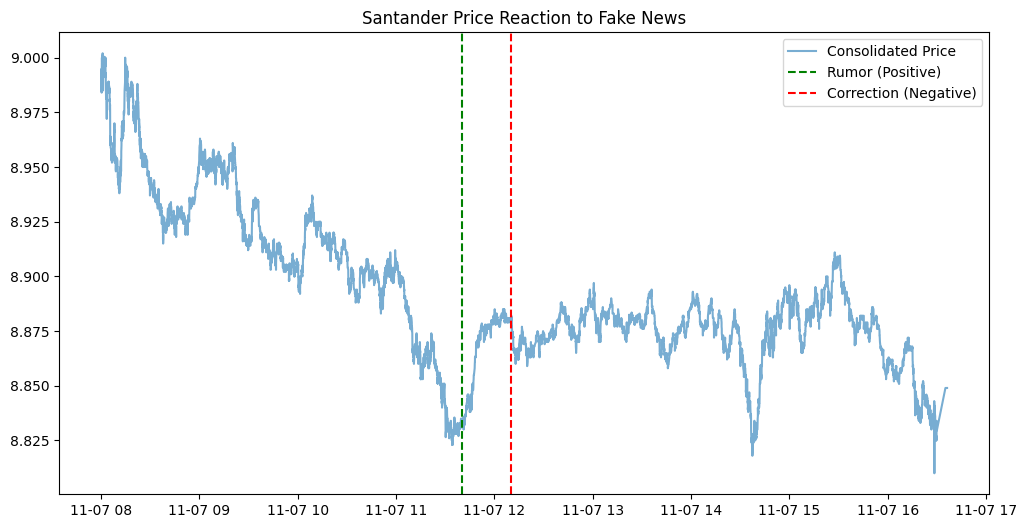

In [23]:
import matplotlib.pyplot as plt

# Plotting the Clean Tape Price
plt.figure(figsize=(12, 6))
plt.plot(clean_tape.index, clean_tape['px'], label='Consolidated Price', alpha=0.6)

# Add vertical lines for our News events
plt.axvline(pd.Timestamp('2025-11-07 11:40:00'), color='green', linestyle='--', label='Rumor (Positive)')
plt.axvline(pd.Timestamp('2025-11-07 12:10:00'), color='red', linestyle='--', label='Correction (Negative)')

plt.title("Santander Price Reaction to Fake News")
plt.legend()
plt.show()

### Plotting the pivot table

Since we have our pivot table with the prices of XMAD and CBOE together with the corresponding labels, we can use it to plot it

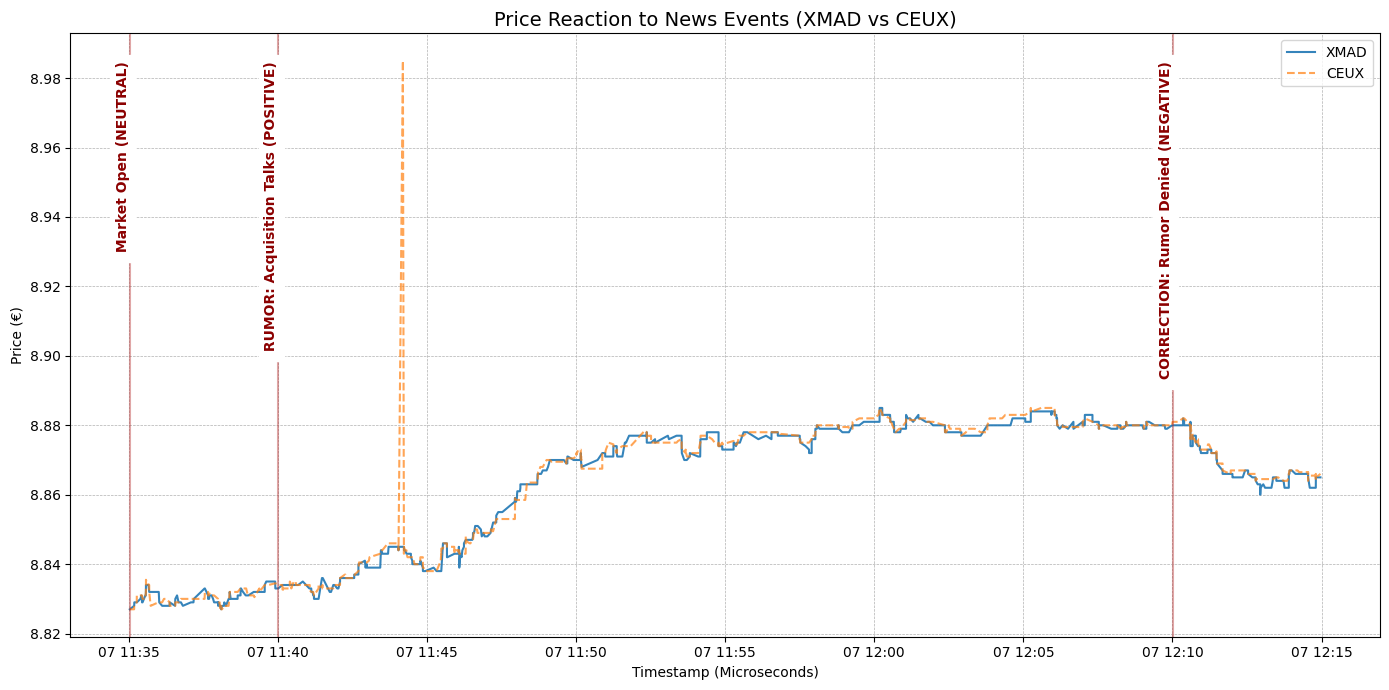

In [24]:
import matplotlib.pyplot as plt


tagged_trades = tagged_trades.between_time("11:35","12:15").copy()

# Create the figure and axis
plt.figure(figsize=(14, 7))

# 1. Plot Prices from both venues
# We plot both to see if arbitrage opportunities (gaps) open up during news events
plt.plot(tagged_trades.index, tagged_trades['XMAD'], label='XMAD', linewidth=1.5, alpha=0.9)
plt.plot(tagged_trades.index, tagged_trades['CEUX'], label='CEUX', linewidth=1.5, alpha=0.7, linestyle='--')

# 2. Identify where the headline changes
# We check where the 'headline' column value is different from the previous row.
# This recovers the exact moment our merge_asof "switched" to a new news item.
headline_changes = tagged_trades[tagged_trades['headline'] != tagged_trades['headline'].shift()]

# 3. Annotate the plot
# We get the max price to position the text labels at the top of the chart
y_max = tagged_trades[['XMAD', 'CEUX']].max().max()

for ts, row in headline_changes.iterrows():
    # Vertical line for the event
    plt.axvline(x=ts, color='firebrick', linestyle='-', alpha=0.4)
    
    # Text annotation
    label_text = f" {row['headline']} ({row['sentiment']})"
    
    plt.text(x=ts, y=y_max, s=label_text, 
             rotation=90, 
             verticalalignment='top', 
             horizontalalignment='right', # Right align so text is to the left of the line (looking back)
             fontsize=10, 
             color='darkred',
             fontweight='bold',
             backgroundcolor='white') # White background to make text readable over grid lines

# Final Formatting
plt.title("Price Reaction to News Events (XMAD vs CEUX)", fontsize=14)
plt.ylabel("Price (€)")
plt.xlabel("Timestamp (Microseconds)")
plt.legend(loc='best')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# STEP 1: Data Ingestion & Cleaning for Arbitrage Detection

Now we will implement the requirements for the arbitrage study. We need to:
1. Load **QTE** (order book quotes) files instead of TRD
2. Load **STS** (trading status) files
3. Filter out "magic numbers" (invalid prices like 999,999)
4. Ensure orderbooks are "addressable" (market is in continuous trading)
5. Load data from all 4 venues: BME (XMAD), CBOE (CEUX), AQUIS (AQEU), TURQUOISE (TQEX)

In [ ]:
# Configuration for arbitrage detection
SESSION = '2025-11-07'

# Selected ISINs for analysis (5 major Spanish stocks)
ISINS_TO_PROCESS = {
    'ES0113900J37': 'Banco Santander (SAN)',
    'ES0113211835': 'Inditex (ITX)', 
    'ES0144580Y14': 'Telefónica (TEF)',
    'ES0178430E18': 'Iberdrola (IBE)',
    'ES0113679I37': 'BBVA'
}

# Define the venues and their corresponding MICs
VENUES = {
    'BME': {'folder': 'BME_2025-11-07', 'mic': 'XMAD'},
    'CBOE': {'folder': 'CBOE_2025-11-07', 'mic': 'CEUX'},
    'AQUIS': {'folder': 'AQUIS_2025-11-07', 'mic': 'AQEU'},
    'TURQUOISE': {'folder': 'TURQUOISE_2025-11-07', 'mic': 'TQEX'}
}

# Magic numbers to filter (from vendor specifications)
MAGIC_NUMBERS = [
    666666.666,  # Unquoted/Unknown
    999999.999,  # Market Order (At Best)
    999999.989,  # At Open Order
    999999.988,  # At Close Order
    999999.979,  # Pegged Order
    999999.123,  # Unquoted/Unknown
    0.0          # Zero price (invalid)
]

# Valid trading status codes per venue (Continuous Trading only)
VALID_TRADING_STATUS = {
    'AQEU': [5308427],
    'XMAD': [5832713, 5832756],
    'CEUX': [12255233],
    'TQEX': [7608181]
}

print(f"Configuration loaded:")
print(f"  Session: {SESSION}")
print(f"  ISINs to process: {len(ISINS_TO_PROCESS)}")
for isin, name in ISINS_TO_PROCESS.items():
    print(f"    - {isin}: {name}")
print(f"  Venues: {list(VENUES.keys())}")
print(f"  Magic numbers to filter: {len(MAGIC_NUMBERS)}")

## 1.1 Loading QTE (Order Book Quotes) Files

QTE files contain the order book snapshots with bid/ask prices and quantities at multiple levels (0-9).
We need columns: `epoch`, `px_bid_0`, `px_ask_0`, `qty_bid_0`, `qty_ask_0`

In [ ]:
def load_qte_file(isin, venue_name, venue_info, session):
    """
    Load a QTE (quotes) file for a specific ISIN and venue.
    Returns a DataFrame with order book snapshots.
    """
    folder = venue_info['folder']
    mic = venue_info['mic']
    
    # Find the file matching this ISIN and MIC
    import glob
    pattern = f'DATA_BIG/{folder}/QTE_{session}_{isin}_*_{mic}_*.csv.gz'
    files = glob.glob(pattern)
    
    if not files:
        print(f"  ✗ No file found for {venue_name} ({mic})")
        return None
    
    file_path = files[0]  # Take the first match
    
    try:
        # Load the file
        df = pd.read_csv(file_path, sep=';', compression='gzip')
        
        # Select only the columns we need
        cols_needed = ['epoch', 'sequence', 'px_bid_0', 'px_ask_0', 'qty_bid_0', 'qty_ask_0', 'mic']
        df = df[cols_needed].copy()
        
        # Add venue name for identification
        df['venue'] = venue_name
        df['isin'] = isin
        
        print(f"  ✓ {venue_name:10s} ({mic:4s}): {len(df):,} quotes")
        return df
    
    except Exception as e:
        print(f"  ✗ Error loading {venue_name}: {e}")
        return None

# Test loading one ISIN
print("Testing QTE load for Santander:")
print("-" * 60)
df_test = load_qte_file('ES0113900J37', 'BME', VENUES['BME'], SESSION)
if df_test is not None:
    display(df_test.head(3))
    print(f"\nColumns: {df_test.columns.tolist()}")

## 1.2 Loading STS (Trading Status) Files

STS files tell us when the market is open for continuous trading.
We only want to consider orderbook snapshots when the market is actually tradeable.

In [ ]:
def load_sts_file(isin, venue_name, venue_info, session):
    """
    Load an STS (trading status) file for a specific ISIN and venue.
    Returns a DataFrame with market status updates.
    """
    folder = venue_info['folder']
    mic = venue_info['mic']
    
    # Find the file matching this ISIN and MIC
    import glob
    pattern = f'DATA_BIG/{folder}/STS_{session}_{isin}_*_{mic}_*.csv.gz'
    files = glob.glob(pattern)
    
    if not files:
        print(f"  ✗ No STS file found for {venue_name} ({mic})")
        return None
    
    file_path = files[0]
    
    try:
        # Load the file
        df = pd.read_csv(file_path, sep=';', compression='gzip')
        
        # Select only the columns we need
        cols_needed = ['epoch', 'sequence', 'market_trading_status', 'mic']
        df = df[cols_needed].copy()
        
        # Add venue name
        df['venue'] = venue_name
        df['isin'] = isin
        
        print(f"  ✓ {venue_name:10s} ({mic:4s}): {len(df):,} status updates")
        return df
    
    except Exception as e:
        print(f"  ✗ Error loading {venue_name}: {e}")
        return None

# Test loading one venue
print("Testing STS load for Santander:")
print("-" * 60)
df_sts_test = load_sts_file('ES0113900J37', 'BME', VENUES['BME'], SESSION)
if df_sts_test is not None:
    display(df_sts_test.head(3))
    print(f"\nUnique trading statuses: {sorted(df_sts_test['market_trading_status'].unique())}")

## 1.3 Load All Venues

Now let's load QTE and STS data from all 4 venues.

In [ ]:
# Load QTE and STS files for all ISINs and venues
print("=" * 80)
print("LOADING DATA FOR ALL ISINs")
print("=" * 80)

qte_dataframes = {}
sts_dataframes = {}

for isin, name in ISINS_TO_PROCESS.items():
    print(f"\n{name} ({isin}):")
    print("-" * 60)
    
    qte_dataframes[isin] = {}
    sts_dataframes[isin] = {}
    
    # Load QTE files
    print("QTE Files:")
    for venue_name, venue_info in VENUES.items():
        df = load_qte_file(isin, venue_name, venue_info, SESSION)
        if df is not None:
            qte_dataframes[isin][venue_name] = df
    
    # Load STS files
    print("\nSTS Files:")
    for venue_name, venue_info in VENUES.items():
        df = load_sts_file(isin, venue_name, venue_info, SESSION)
        if df is not None:
            sts_dataframes[isin][venue_name] = df

print("\n" + "=" * 80)
print("LOADING SUMMARY:")
print("=" * 80)
for isin, name in ISINS_TO_PROCESS.items():
    qte_count = len(qte_dataframes.get(isin, {}))
    sts_count = len(sts_dataframes.get(isin, {}))
    print(f"{name:25s}: QTE={qte_count}/4 venues, STS={sts_count}/4 venues")

## 1.4 Data Cleaning: Filter Magic Numbers

The vendor uses special high-value constants (like 999,999) to indicate non-tradable states.
We must remove these before any analysis.

In [ ]:
def filter_magic_numbers(df, magic_numbers=MAGIC_NUMBERS):
    """
    Remove rows where bid or ask prices are 'magic numbers' (invalid prices).
    Also remove rows where bid/ask are NaN or where quantities are 0 or NaN.
    """
    original_len = len(df)
    
    # Filter out magic numbers in prices
    for magic in magic_numbers:
        df = df[df['px_bid_0'] != magic]
        df = df[df['px_ask_0'] != magic]
    
    # Filter out NaN prices
    df = df.dropna(subset=['px_bid_0', 'px_ask_0'])
    
    # Filter out zero or NaN quantities
    df = df[(df['qty_bid_0'] > 0) & (df['qty_ask_0'] > 0)]
    df = df.dropna(subset=['qty_bid_0', 'qty_ask_0'])
    
    # Additional sanity check: bid should be less than ask
    df = df[df['px_bid_0'] < df['px_ask_0']]
    
    # Additional check: filter out unreasonably high prices (likely missed magic numbers)
    # Most stocks trade under 100 EUR, so anything above 100 is suspicious
    df = df[(df['px_bid_0'] < 100) & (df['px_ask_0'] < 100)]
    
    removed = original_len - len(df)
    if removed > 0:
        pct = removed/original_len*100
        print(f"    Removed {removed:,} invalid quotes ({pct:.2f}%)")
    
    return df

# Apply filtering to all QTE dataframes
print("=" * 80)
print("FILTERING MAGIC NUMBERS")
print("=" * 80)

for isin, name in ISINS_TO_PROCESS.items():
    print(f"\n{name} ({isin}):")
    for venue_name in qte_dataframes.get(isin, {}).keys():
        print(f"  {venue_name}:")
        qte_dataframes[isin][venue_name] = filter_magic_numbers(qte_dataframes[isin][venue_name])
        remaining = len(qte_dataframes[isin][venue_name])
        print(f"    Remaining: {remaining:,} valid quotes")

## 1.5 Apply Addressability Filter (Trading Hours)

Since the trading status codes vary by venue and are not well documented, we'll use a simpler approach:
filter quotes to only include those during regular trading hours (09:00 - 17:30).

In [ ]:
def apply_addressability_filter(qte_df, sts_df, mic):
    """
    Merge QTE data with STS data to determine which quotes are 'addressable'
    (i.e., the market was in continuous trading).
    Uses venue-specific trading status codes.
    """
    # Get valid status codes for this MIC
    valid_statuses = VALID_TRADING_STATUS.get(mic, [])
    
    if not valid_statuses:
        print(f"    ⚠ Warning: No valid status codes defined for {mic}, keeping all quotes")
        return qte_df
    
    original_len = len(qte_df)
    
    # Sort both dataframes by epoch
    qte_sorted = qte_df.sort_values('epoch').copy()
    sts_sorted = sts_df.sort_values('epoch').copy()
    
    # Merge as-of: for each quote, find the most recent trading status
    merged = pd.merge_asof(
        qte_sorted,
        sts_sorted[['epoch', 'market_trading_status']],
        on='epoch',
        direction='backward'
    )
    
    # Filter to keep only addressable quotes
    addressable = merged[merged['market_trading_status'].isin(valid_statuses)].copy()
    
    removed = original_len - len(addressable)
    pct = removed/original_len*100 if original_len > 0 else 0
    print(f"    Removed {removed:,} non-addressable quotes ({pct:.2f}%)")
    print(f"    Remaining: {len(addressable):,} addressable quotes")
    
    return addressable

# Apply addressability filter to all venues
print("=" * 80)
print("APPLYING ADDRESSABILITY FILTER (Continuous Trading Only)")
print("=" * 80)

qte_addressable = {}
for isin, name in ISINS_TO_PROCESS.items():
    print(f"\n{name} ({isin}):")
    qte_addressable[isin] = {}
    
    for venue_name in qte_dataframes.get(isin, {}).keys():
        if venue_name in sts_dataframes.get(isin, {}):
            print(f"  {venue_name}:")
            mic = VENUES[venue_name]['mic']
            qte_addressable[isin][venue_name] = apply_addressability_filter(
                qte_dataframes[isin][venue_name],
                sts_dataframes[isin][venue_name],
                mic
            )
        else:
            print(f"  ⚠ {venue_name}: No STS data, keeping all quotes")
            qte_addressable[isin][venue_name] = qte_dataframes[isin][venue_name]

## 1.6 Apply Timestamp Cleaning (Nanosecond Trick)

Now we apply the same timestamp cleaning technique we learned earlier to handle multiple quotes at the same microsecond.

In [ ]:
def clean_timestamps_qte(df):
    """
    Apply the nanosecond trick to create unique timestamps for quotes
    that occur at the same microsecond.
    """
    # Sort by epoch and sequence
    df = df.sort_values(by=['epoch', 'sequence'], ascending=[True, True])
    
    # Convert to timestamp
    temp_ts = pd.to_datetime(df['epoch'], unit='us')
    
    # Add nanosecond offset for duplicates
    offset_ns = df.groupby('epoch').cumcount()
    
    max_offset = offset_ns.max()
    if max_offset > 1000:
        print(f"    ⚠ Warning: Up to {max_offset} quotes at the same microsecond")
    
    # Create unique timestamp
    df['ts'] = temp_ts + pd.to_timedelta(offset_ns, unit='ns')
    
    # Set as index
    df.set_index('ts', inplace=True)
    
    return df

# Apply timestamp cleaning to all venues
print("=" * 80)
print("APPLYING TIMESTAMP CLEANING (Nanosecond Trick)")
print("=" * 80)

qte_clean = {}
for isin, name in ISINS_TO_PROCESS.items():
    print(f"\n{name} ({isin}):")
    qte_clean[isin] = {}
    
    for venue_name, df in qte_addressable.get(isin, {}).items():
        print(f"  {venue_name}:")
        qte_clean[isin][venue_name] = clean_timestamps_qte(df)
        is_unique = qte_clean[isin][venue_name].index.is_unique
        total = len(qte_clean[isin][venue_name])
        print(f"    Index unique: {is_unique}, Total quotes: {total:,}")

print("\n" + "=" * 80)
print("✓ Step 1 Complete: Data Ingestion & Cleaning")
print("=" * 80)

## 1.7 Verify the Cleaned Data

Let's inspect the cleaned data to make sure everything looks correct.

In [ ]:
# Summary statistics for all ISINs
print("=" * 80)
print("STEP 1 SUMMARY: CLEANED DATA")
print("=" * 80)

for isin, name in ISINS_TO_PROCESS.items():
    print(f"\n{name} ({isin}):")
    print("-" * 60)
    
    summary_data = []
    for venue_name, df in qte_clean.get(isin, {}).items():
        if len(df) > 0:
            summary_data.append({
                'Venue': venue_name,
                'MIC': df['mic'].iloc[0],
                'Quotes': len(df),
                'Avg Bid': f"€{df['px_bid_0'].mean():.3f}",
                'Avg Ask': f"€{df['px_ask_0'].mean():.3f}",
                'Avg Spread': f"€{(df['px_ask_0'] - df['px_bid_0']).mean():.4f}",
                'Time Range': f"{df.index.min().strftime('%H:%M')} - {df.index.max().strftime('%H:%M')}"
            })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        display(summary_df)
    else:
        print("  No data available")

# Overall statistics
print("\n" + "=" * 80)
print("OVERALL STATISTICS:")
print("=" * 80)

total_quotes = 0
for isin in qte_clean:
    for venue in qte_clean[isin]:
        total_quotes += len(qte_clean[isin][venue])

print(f"Total ISINs processed: {len(ISINS_TO_PROCESS)}")
print(f"Total venues per ISIN: {len(VENUES)}")
print(f"Total quotes cleaned: {total_quotes:,}")
print(f"Average quotes per ISIN: {total_quotes/len(ISINS_TO_PROCESS):,.0f}")

# STEP 2: Create the Consolidated Tape

Now we need to combine the order book data from all 4 venues into a single time-series view.
This allows us to compare prices across venues at any given microsecond and detect arbitrage opportunities.

**Key Concept:** Since venues update asynchronously, we use **forward fill (`ffill`)** to propagate the last known price until a new update arrives.

In [ ]:
def create_consolidated_tape(qte_dict, isin):
    """
    Create a consolidated tape for a single ISIN across all venues.
    
    Returns a DataFrame with columns for each venue's bid/ask prices and quantities.
    Index is the timestamp (unique across all venues).
    """
    # Combine all venue data
    all_data = []
    for venue_name, df in qte_dict.items():
        # Create a copy with venue-specific column names
        df_copy = df.copy()
        df_copy['venue_name'] = venue_name
        all_data.append(df_copy)
    
    if not all_data:
        return None
    
    # Concatenate all venues
    combined = pd.concat(all_data)
    combined = combined.sort_index()
    
    # Pivot to create columns for each venue
    # We need: bid_VENUE, ask_VENUE, bid_qty_VENUE, ask_qty_VENUE
    tape = pd.DataFrame(index=combined.index.unique())
    
    for venue_name in qte_dict.keys():
        venue_data = combined[combined['venue_name'] == venue_name]
        
        # Add bid/ask prices
        tape[f'bid_{venue_name}'] = venue_data['px_bid_0']
        tape[f'ask_{venue_name}'] = venue_data['px_ask_0']
        
        # Add bid/ask quantities
        tape[f'bid_qty_{venue_name}'] = venue_data['qty_bid_0']
        tape[f'ask_qty_{venue_name}'] = venue_data['qty_ask_0']
    
    # Forward fill to propagate last known prices
    tape = tape.ffill()
    
    # Drop rows where we don't have data from all venues yet
    # (at the start of the day, not all venues may have reported)
    tape = tape.dropna()
    
    return tape

# Test with Santander
print("Creating consolidated tape for Santander...")
print("-" * 60)

test_isin = 'ES0113900J37'
test_tape = create_consolidated_tape(qte_clean[test_isin], test_isin)

if test_tape is not None:
    print(f"Consolidated tape created: {len(test_tape):,} timestamps")
    print(f"Columns: {test_tape.columns.tolist()}")
    print(f"\nSample data:")
    display(test_tape.head(3))
    
    # Show a specific moment to see price differences
    print(f"\nSample at 11:00:00:")
    sample_time = test_tape.between_time('11:00:00', '11:00:01')
    if len(sample_time) > 0:
        display(sample_time.head(1))

## 2.1 Detect Arbitrage Opportunities

An arbitrage opportunity exists when:
**Global Max Bid > Global Min Ask**

This means we can buy at the lowest ask price on one venue and simultaneously sell at the highest bid price on another venue.

In [ ]:
def detect_arbitrage_opportunities(tape, venues):
    """
    Detect arbitrage opportunities in the consolidated tape.
    
    Returns the tape with additional columns:
    - max_bid: highest bid across all venues
    - min_ask: lowest ask across all venues
    - max_bid_venue: venue with highest bid
    - min_ask_venue: venue with lowest ask
    - spread: max_bid - min_ask (positive = arbitrage opportunity)
    - available_qty: minimum of bid_qty and ask_qty (tradeable volume)
    - profit: spread * available_qty (theoretical profit in EUR)
    """
    # Get all bid and ask columns
    bid_cols = [f'bid_{v}' for v in venues]
    ask_cols = [f'ask_{v}' for v in venues]
    
    # Find max bid and min ask across venues
    tape['max_bid'] = tape[bid_cols].max(axis=1)
    tape['min_ask'] = tape[ask_cols].min(axis=1)
    
    # Find which venues have the max bid and min ask
    tape['max_bid_venue'] = tape[bid_cols].idxmax(axis=1).str.replace('bid_', '')
    tape['min_ask_venue'] = tape[ask_cols].idxmin(axis=1).str.replace('ask_', '')
    
    # Calculate spread (arbitrage opportunity exists when spread > 0)
    tape['spread'] = tape['max_bid'] - tape['min_ask']
    
    # Get available quantities at the best prices
    tape['bid_qty_at_max'] = tape.apply(
        lambda row: row[f"bid_qty_{row['max_bid_venue']}"], axis=1
    )
    tape['ask_qty_at_min'] = tape.apply(
        lambda row: row[f"ask_qty_{row['min_ask_venue']}"], axis=1
    )
    
    # Available quantity is the minimum of the two
    tape['available_qty'] = tape[['bid_qty_at_max', 'ask_qty_at_min']].min(axis=1)
    
    # Calculate theoretical profit (in EUR)
    tape['profit'] = tape['spread'] * tape['available_qty']
    
    # Flag arbitrage opportunities (spread > 0)
    tape['is_arbitrage'] = tape['spread'] > 0
    
    return tape

# Apply to Santander
print("Detecting arbitrage opportunities for Santander...")
print("-" * 60)

test_tape = detect_arbitrage_opportunities(test_tape, list(qte_clean[test_isin].keys()))

# Show statistics
arb_opportunities = test_tape[test_tape['is_arbitrage']]
print(f"\nTotal timestamps: {len(test_tape):,}")
print(f"Arbitrage opportunities: {len(arb_opportunities):,} ({len(arb_opportunities)/len(test_tape)*100:.2f}%)")

if len(arb_opportunities) > 0:
    print(f"\nArbitrage Statistics:")
    print(f"  Average spread: €{arb_opportunities['spread'].mean():.6f}")
    print(f"  Max spread: €{arb_opportunities['spread'].max():.6f}")
    print(f"  Total theoretical profit: €{arb_opportunities['profit'].sum():,.2f}")
    
    print(f"\nTop 5 arbitrage opportunities:")
    display(arb_opportunities.nlargest(5, 'profit')[
        ['max_bid', 'min_ask', 'spread', 'max_bid_venue', 'min_ask_venue', 'available_qty', 'profit']
    ])

## 2.2 Rising Edge Detection

**Critical:** If an arbitrage opportunity persists for multiple timestamps, we can only trade it **once** (the first time it appears).

We need to detect the "rising edge" - when an opportunity appears for the first time or reappears after disappearing.

In [ ]:
def detect_rising_edges(tape):
    """
    Detect rising edges: the first timestamp where an arbitrage opportunity appears.
    
    A rising edge occurs when:
    - Current row has arbitrage (is_arbitrage = True)
    - Previous row did NOT have arbitrage (is_arbitrage = False)
    
    Returns the tape with an additional 'is_rising_edge' column.
    """
    # Shift to get previous row's arbitrage status
    tape['prev_is_arbitrage'] = tape['is_arbitrage'].shift(1, fill_value=False)
    
    # Rising edge: current is True, previous is False
    tape['is_rising_edge'] = tape['is_arbitrage'] & ~tape['prev_is_arbitrage']
    
    return tape

# Apply rising edge detection
print("Detecting rising edges for Santander...")
print("-" * 60)

test_tape = detect_rising_edges(test_tape)

# Show statistics
rising_edges = test_tape[test_tape['is_rising_edge']]
print(f"\nTotal arbitrage opportunities: {test_tape['is_arbitrage'].sum():,}")
print(f"Unique trading opportunities (rising edges): {len(rising_edges):,}")
print(f"Average duration per opportunity: {test_tape['is_arbitrage'].sum() / len(rising_edges):.1f} timestamps")

if len(rising_edges) > 0:
    print(f"\nRising Edge Statistics:")
    print(f"  Total profit (0 latency): €{rising_edges['profit'].sum():,.2f}")
    print(f"  Average profit per trade: €{rising_edges['profit'].mean():.4f}")
    print(f"  Max profit per trade: €{rising_edges['profit'].max():.2f}")
    
    print(f"\nTop 5 trading opportunities:")
    display(rising_edges.nlargest(5, 'profit')[
        ['max_bid', 'min_ask', 'spread', 'max_bid_venue', 'min_ask_venue', 'available_qty', 'profit']
    ])

## 2.3 Process All ISINs

Now let's apply the consolidated tape creation and arbitrage detection to all 5 ISINs.

In [ ]:
# Process all ISINs
print("=" * 80)
print("PROCESSING ALL ISINs: CONSOLIDATED TAPE & ARBITRAGE DETECTION")
print("=" * 80)

consolidated_tapes = {}
arbitrage_results = {}

for isin, name in ISINS_TO_PROCESS.items():
    print(f"\n{name} ({isin}):")
    print("-" * 60)
    
    # Create consolidated tape
    tape = create_consolidated_tape(qte_clean[isin], isin)
    
    if tape is None or len(tape) == 0:
        print("  ✗ No data available")
        continue
    
    print(f"  ✓ Consolidated tape: {len(tape):,} timestamps")
    
    # Detect arbitrage
    tape = detect_arbitrage_opportunities(tape, list(qte_clean[isin].keys()))
    tape = detect_rising_edges(tape)
    
    # Store results
    consolidated_tapes[isin] = tape
    
    # Calculate statistics
    arb_count = tape['is_arbitrage'].sum()
    rising_edge_count = tape['is_rising_edge'].sum()
    total_profit = tape.loc[tape['is_rising_edge'], 'profit'].sum()
    
    arbitrage_results[isin] = {
        'name': name,
        'total_timestamps': len(tape),
        'arbitrage_opportunities': arb_count,
        'unique_trades': rising_edge_count,
        'total_profit': total_profit,
        'avg_profit_per_trade': total_profit / rising_edge_count if rising_edge_count > 0 else 0,
        'arbitrage_pct': arb_count / len(tape) * 100 if len(tape) > 0 else 0
    }
    
    print(f"  Arbitrage opportunities: {arb_count:,} ({arb_count/len(tape)*100:.2f}%)")
    print(f"  Unique trades (rising edges): {rising_edge_count:,}")
    print(f"  Total profit (0 latency): €{total_profit:,.2f}")
    if rising_edge_count > 0:
        print(f"  Avg profit per trade: €{total_profit/rising_edge_count:.4f}")

print("\n" + "=" * 80)
print("✓ Step 2 Complete: Consolidated Tape & Arbitrage Detection")
print("=" * 80)

## 2.4 Summary Results

Let's create a summary table comparing arbitrage opportunities across all ISINs.

In [ ]:
# Create summary table
print("=" * 80)
print("STEP 2 SUMMARY: ARBITRAGE OPPORTUNITIES BY ISIN")
print("=" * 80)

summary_data = []
for isin, results in arbitrage_results.items():
    summary_data.append({
        'ISIN': isin,
        'Name': results['name'],
        'Total Timestamps': f"{results['total_timestamps']:,}",
        'Arb Opportunities': f"{results['arbitrage_opportunities']:,}",
        'Arb %': f"{results['arbitrage_pct']:.2f}%",
        'Unique Trades': results['unique_trades'],
        'Total Profit (€)': f"{results['total_profit']:,.2f}",
        'Avg Profit/Trade (€)': f"{results['avg_profit_per_trade']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

# Overall statistics
print("\n" + "=" * 80)
print("OVERALL STATISTICS:")
print("=" * 80)

total_trades = sum(r['unique_trades'] for r in arbitrage_results.values())
total_profit = sum(r['total_profit'] for r in arbitrage_results.values())
total_timestamps = sum(r['total_timestamps'] for r in arbitrage_results.values())

print(f"Total timestamps across all ISINs: {total_timestamps:,}")
print(f"Total unique trading opportunities: {total_trades:,}")
print(f"Total profit (0 latency assumption): €{total_profit:,.2f}")
print(f"Average profit per trade: €{total_profit/total_trades:.4f}" if total_trades > 0 else "N/A")

# Venue pair analysis for Santander (as example)
print("\n" + "=" * 80)
print("VENUE PAIR ANALYSIS (Santander Example):")
print("=" * 80)

santander_isin = 'ES0113900J37'
if santander_isin in consolidated_tapes:
    tape = consolidated_tapes[santander_isin]
    rising_edges = tape[tape['is_rising_edge']]
    
    if len(rising_edges) > 0:
        # Count venue pairs
        venue_pairs = rising_edges.groupby(['max_bid_venue', 'min_ask_venue']).agg({
            'profit': ['count', 'sum', 'mean']
        }).round(4)
        venue_pairs.columns = ['Count', 'Total Profit (€)', 'Avg Profit (€)']
        venue_pairs = venue_pairs.sort_values('Total Profit (€)', ascending=False)
        
        print("\nMost profitable venue pairs (Buy from → Sell to):")
        display(venue_pairs.head(10))

## 2.5 Visualizations

Let's create some visualizations to better understand the arbitrage opportunities.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Profit distribution across ISINs
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Step 2: Arbitrage Analysis Results', fontsize=16, fontweight='bold')

# Plot 1: Total profit by ISIN
ax1 = axes[0, 0]
isins = [r['name'].split('(')[0].strip() for r in arbitrage_results.values()]
profits = [r['total_profit'] for r in arbitrage_results.values()]
ax1.bar(isins, profits, color='steelblue', alpha=0.7)
ax1.set_title('Total Profit by ISIN (0 Latency)', fontweight='bold')
ax1.set_ylabel('Profit (€)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Number of trading opportunities
ax2 = axes[0, 1]
trades = [r['unique_trades'] for r in arbitrage_results.values()]
ax2.bar(isins, trades, color='coral', alpha=0.7)
ax2.set_title('Number of Trading Opportunities', fontweight='bold')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Average profit per trade
ax3 = axes[1, 0]
avg_profits = [r['avg_profit_per_trade'] for r in arbitrage_results.values()]
ax3.bar(isins, avg_profits, color='mediumseagreen', alpha=0.7)
ax3.set_title('Average Profit per Trade', fontweight='bold')
ax3.set_ylabel('Profit (€)')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Arbitrage opportunity percentage
ax4 = axes[1, 1]
arb_pcts = [r['arbitrage_pct'] for r in arbitrage_results.values()]
ax4.bar(isins, arb_pcts, color='mediumpurple', alpha=0.7)
ax4.set_title('Arbitrage Opportunity %', fontweight='bold')
ax4.set_ylabel('Percentage (%)')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Time series of spread for Santander (sample period)
if santander_isin in consolidated_tapes:
    tape = consolidated_tapes[santander_isin]
    
    # Sample a 5-minute window
    sample_start = '10:00:00'
    sample_end = '10:05:00'
    sample = tape.between_time(sample_start, sample_end)
    
    if len(sample) > 0:
        fig, ax = plt.subplots(figsize=(15, 6))
        
        # Plot spread over time
        ax.plot(sample.index, sample['spread'], linewidth=0.5, alpha=0.7, label='Spread')
        
        # Highlight arbitrage opportunities
        arb_sample = sample[sample['is_arbitrage']]
        ax.scatter(arb_sample.index, arb_sample['spread'], 
                  color='red', s=10, alpha=0.5, label='Arbitrage Opportunity', zorder=5)
        
        # Highlight rising edges
        rising_sample = sample[sample['is_rising_edge']]
        ax.scatter(rising_sample.index, rising_sample['spread'], 
                  color='green', s=50, marker='^', label='Trading Opportunity', zorder=10)
        
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_title(f'Santander: Spread Over Time ({sample_start} - {sample_end})', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Time')
        ax.set_ylabel('Spread (€)')
        ax.legend()
        ax.grid(alpha=0.3)
        
        # Format x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Sample period: {sample_start} - {sample_end}")
        print(f"Total timestamps: {len(sample):,}")
        print(f"Arbitrage opportunities: {sample['is_arbitrage'].sum():,}")
        print(f"Trading opportunities (rising edges): {sample['is_rising_edge'].sum():,}")